In [1]:
# add the autoreload
%load_ext autoreload
%autoreload 2

import torch
from epsilon_transformers.analysis.load_data import S3ModelLoader
from epsilon_transformers.analysis.activation_analysis import prepare_msp_data
from scripts.activation_analysis.data_loading import ActivationExtractor
from scripts.activation_analysis.config import TRANSFORMER_ACTIVATION_KEYS
from scripts.activation_analysis.regression import (
    RegressionAnalyzer,
    run_single_rcond_sweep_with_predictions,
    run_single_rcond_sweep_with_predictions_flat,
    run_paul_rcond_sweep_with_sklearn_predictions_flat,
    run_activation_to_beliefs_regression_kf,
    run_activation_to_beliefs_regression_ridgecv,
    run_activation_to_beliefs_regression_pca
)
from scripts.activation_analysis.config import RCOND_SWEEP_LIST


2025-04-21 20:04:29,692 - root - INFO - Logging session started. Log file: logs/analysis_20250421_200429.log


In [7]:


def compute_kfold_split(flat_probs, n_splits=5, random_state=42):
    from sklearn.model_selection import KFold
    import numpy as np

    # If flat_probs is a PyTorch tensor, convert it to numpy
    if isinstance(flat_probs, torch.Tensor):
        flat_probs = flat_probs.cpu().detach().numpy()
    
    # Create position indices
    all_positions = np.arange(len(flat_probs))
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


    
    # Return the KFold object and positions
    # kf is a list of tuples, each tuple contains two lists: the indices of the training set and the indices of the test set
    return kf, all_positions

def find_duplicate_prefixes(nn_inputs):
    """
    Find duplicate prefixes in the input sequences and return their indices.
    
    Args:
        nn_inputs: Tensor of shape (batch_size, seq_len) containing token sequences
        
    Returns:
        Dictionary mapping each unique prefix tuple to a list of (seq_idx, pos) tuples
    """
    batch_size, seq_len = nn_inputs.shape
    prefix_to_indices = {}  # (prefix tuple) -> list of (seq_idx, pos) tuples
    
    # Process each sequence and position
    for seq_idx in range(batch_size):
        seq = nn_inputs[seq_idx]
        
        for pos in range(seq_len):
            # Get the prefix up to this position
            prefix = tuple(seq[:pos+1].cpu().numpy().tolist())
            
            # Add this occurrence to our mapping
            if prefix not in prefix_to_indices:
                prefix_to_indices[prefix] = []
            prefix_to_indices[prefix].append((seq_idx, pos))
    
    return prefix_to_indices

def combine_duplicate_data(prefix_to_indices, activations, nn_probs, belief_states, debug=False, tolerance=1e-6):
    """
    Combine data for duplicate prefixes by summing probabilities.
    
    Args:
        prefix_to_indices: Dictionary mapping prefixes to lists of (seq_idx, pos) tuples
        activations: Tensor of shape (batch_size, seq_len, d_model)
        nn_probs: Tensor of shape (batch_size, seq_len)
        belief_states: Tensor of shape (batch_size, seq_len, belief_dim)
        debug: Whether to print debug information
        tolerance: Tolerance for activation differences
        
    Returns:
        Tuple of (unique_activations, summed_probs, unique_beliefs, unique_prefixes)
    """
    # Dictionary to store unique activations and summed probabilities
    unique_data = {}  # (prefix tuple) -> (activation, summed_prob, belief_state, count)
    
    # Debug information
    if debug:
        activation_diffs = {}  # (prefix tuple) -> max difference observed
        inconsistent_prefixes = []
    
    # Process each unique prefix
    for prefix, indices_list in prefix_to_indices.items():
        first_seq_idx, first_pos = indices_list[0]
        act = activations[first_seq_idx, first_pos]
        prob = nn_probs[first_seq_idx, first_pos]
        belief = belief_states[first_seq_idx, first_pos]
        count = 1
        
        # Process additional occurrences of this prefix
        for seq_idx, pos in indices_list[1:]:
            current_act = activations[seq_idx, pos]
            current_prob = nn_probs[seq_idx, pos]
            
            if debug:
                # Check if activations are the same
                diff = torch.max(torch.abs(act - current_act)).item()
                
                if diff > tolerance:
                    if prefix not in inconsistent_prefixes:
                        inconsistent_prefixes.append(prefix)
                    
                    current_max_diff = activation_diffs.get(prefix, 0)
                    activation_diffs[prefix] = max(current_max_diff, diff)
            
            # Sum the probabilities
            prob += current_prob
            count += 1
        
        # Store the combined data
        unique_data[prefix] = (act, prob, belief, count)
    
    # Print debug info if requested
    if debug:
        if inconsistent_prefixes:
            print(f"WARNING: Found {len(inconsistent_prefixes)} prefixes with inconsistent activations!")
            print(f"Max differences observed:")
            for prefix in sorted(inconsistent_prefixes, key=lambda p: activation_diffs[p], reverse=True)[:10]:
                print(f"  Prefix {prefix}: max diff = {activation_diffs[prefix]}, seen {unique_data[prefix][3]} times")
        else:
            print("All prefixes have consistent activations (within tolerance).")
            
        total_saved = sum(unique_data[p][3] - 1 for p in unique_data)
        total_items = sum(len(indices) for indices in prefix_to_indices.values())
        print(f"Deduplication saved {total_saved} activations out of {total_items}")
    
    # Convert to tensors
    unique_prefixes = list(unique_data.keys())
    unique_activations = torch.stack([unique_data[p][0] for p in unique_prefixes])
    summed_probs = torch.tensor([unique_data[p][1] for p in unique_prefixes])
    unique_beliefs = torch.stack([unique_data[p][2] for p in unique_prefixes])
    
    return unique_activations, summed_probs, unique_beliefs, unique_prefixes

def deduplicate_tensor(prefix_to_indices, tensor, aggregation_fn=None, debug=False, tolerance=1e-6):
    """
    Deduplicate a single tensor based on prefix indices.
    
    Args:
        prefix_to_indices: Dictionary mapping prefixes to lists of (seq_idx, pos) tuples
        tensor: Tensor of shape (batch_size, seq_len, ...) to deduplicate
        aggregation_fn: Function to aggregate duplicate values (default: take first occurrence)
                        Should accept a list of tensor values and return a single value
        debug: Whether to print debug information
        tolerance: Tolerance for tensor value differences
        
    Returns:
        Tuple of (unique_tensor_values, unique_prefixes)
    """
    # Dictionary to store unique tensor values
    unique_data = {}  # (prefix tuple) -> (tensor_value, count)
    
    # Debug information
    if debug:
        value_diffs = {}  # (prefix tuple) -> max difference observed
        inconsistent_prefixes = []
    
    # Process each unique prefix
    for prefix, indices_list in prefix_to_indices.items():
        first_seq_idx, first_pos = indices_list[0]
        value = tensor[first_seq_idx, first_pos]
        count = 1
        
        # If we have an aggregation function and multiple occurrences, prepare to aggregate
        if aggregation_fn is not None and len(indices_list) > 1:
            values = [value]
            
            # Collect all values for this prefix
            for seq_idx, pos in indices_list[1:]:
                current_value = tensor[seq_idx, pos]
                values.append(current_value)
                
                if debug:
                    # Check if values are the same
                    diff = torch.max(torch.abs(value - current_value)).item()
                    
                    if diff > tolerance:
                        if prefix not in inconsistent_prefixes:
                            inconsistent_prefixes.append(prefix)
                        
                        current_max_diff = value_diffs.get(prefix, 0)
                        value_diffs[prefix] = max(current_max_diff, diff)
                
                count += 1
            
            # Aggregate the values
            value = aggregation_fn(values)
        
        # Store the unique value
        unique_data[prefix] = (value, count)
    
    # Print debug info if requested
    if debug:
        if inconsistent_prefixes:
            print(f"WARNING: Found {len(inconsistent_prefixes)} prefixes with inconsistent values!")
            print(f"Max differences observed:")
            for prefix in sorted(inconsistent_prefixes, key=lambda p: value_diffs[p], reverse=True)[:10]:
                print(f"  Prefix {prefix}: max diff = {value_diffs[prefix]}, seen {unique_data[prefix][1]} times")
        else:
            print("All prefixes have consistent values (within tolerance).")
            
        total_saved = sum(unique_data[p][1] - 1 for p in unique_data)
        total_items = sum(len(indices) for indices in prefix_to_indices.values())
        print(f"Deduplication saved {total_saved} items out of {total_items}")
    
    # Convert to tensor
    unique_prefixes = list(unique_data.keys())
    unique_values = torch.stack([unique_data[p][0] for p in unique_prefixes])
    
    return unique_values, unique_prefixes


def get_nn_type(run_id):
    if 'GRU' in run_id or 'LSTM' in run_id or 'RNN' in run_id or 're' in run_id:
        return "RNN"
    else:
        return "transformer"

def prepare_msp_data_for_regression(
    sweep_id: str,
    run_id: str,
    checkpoint_path: str,
    device: str = "cpu",
):
    """
    Prepare MSP data for regression analysis
    
    Args:
        sweep_id: The sweep ID to load from
        run_id: The run ID to load from
        checkpoint_path: Path to the checkpoint file
        device: Device to run on ('cpu' or 'cuda')
        
    Returns:
        Tuple containing (model, run_config, nn_inputs, nn_beliefs, nn_probs)
    """
    # Load model and prepare data
    s3_loader = S3ModelLoader(use_company_credentials=True)
    model, run_config = s3_loader.load_checkpoint(
        sweep_id, run_id, checkpoint_path, device=device
    )
    
    # Prepare belief data
    n_ctx = run_config["model_config"]["n_ctx"]
    run_config["n_ctx"] = n_ctx
    nn_inputs, nn_beliefs, _, nn_probs, _ = prepare_msp_data(
        run_config, run_config["process_config"]
    )
    
    return model, run_config, nn_inputs, nn_beliefs, nn_probs

def minimal_layerwise_regression(
    model,
    run_id: str,
    nn_inputs,
    nn_beliefs,
    nn_probs,
    device: str = "cpu",
    run_layerwise: bool = False,
    kf: list = None, # list of tuples, each tuple contains two lists: the indices of the training set and the indices of the test set
    prefix_to_indices: dict = None
):
    """
    Minimal script to:
      1) Extract each layer's activations
      2) Run regression layer by layer + 'all_layers_combined'
    
    Args:
        model: The loaded model
        run_id: The run ID (used to determine model type)
        nn_inputs: Neural network inputs
        nn_beliefs: Neural network beliefs
        nn_probs: Neural network probabilities
        device: Device to run on ('cpu' or 'cuda')
        
    Returns:
        Dictionary containing regression results for each layer
    """
    # Extract activations from each layer
    #print("Extracting layer activations...")
    act_extractor = ActivationExtractor(device=device)
    nn_acts = act_extractor.extract_activations(
        model,
        nn_inputs,
        get_nn_type(run_id),
        relevant_activation_keys=TRANSFORMER_ACTIVATION_KEYS,
    )
        # Run regression on combined layers
    #print("\nConcatenating all layer activations...")
    combined_acts = _combine_layer_activations(nn_acts)
    #print(f"All-layers concatenated shape: {combined_acts.shape}")
    #print(f'a single layer act shape: {nn_acts[list(nn_acts.keys())[1]].shape}')

    ##print(f"Found {len(nn_acts)} layer activations.")
    #print(nn_acts.keys())
    #print('first act shape', nn_acts[list(nn_acts.keys())[0]].shape)
    
    # Setup for regression
    regression_analyzer = RegressionAnalyzer(device=device, use_efficient_pinv=True)
    sample_weights = nn_probs / nn_probs.sum()
    layer_results = {}
    
    # Run regression on individual layers
    #print("\nRunning regression for each layer individually...")

    if run_layerwise:
        for layer_key, layer_act in nn_acts.items():
            
            deduplicated_activations, deduplicated_probs, deduplicated_beliefs, unique_prefixes = combine_duplicate_data(prefix_to_indices, layer_act, nn_probs, nn_beliefs, debug=False, tolerance=1e-6)

            #layer_results[layer_key] = _run_regression_for_layer(
            #    regression_analyzer, layer_act, nn_beliefs, sample_weights
            #)
            layer_results[layer_key] = _run_regression_for_layer_flat(
                regression_analyzer, deduplicated_activations, deduplicated_beliefs, deduplicated_probs, kf
            )
    


    deduplicated_activations, deduplicated_probs, deduplicated_beliefs, unique_prefixes = combine_duplicate_data(prefix_to_indices, combined_acts, nn_probs, nn_beliefs, debug=False, tolerance=1e-6)
    
    layer_results["all_layers_combined"] = _run_regression_for_layer_flat(
        regression_analyzer, deduplicated_activations, deduplicated_beliefs, deduplicated_probs, kf
    )
    
    #print("\nDone! Returning results.")

    # if nn_type is transformer then convert the keys to layers
    if get_nn_type(run_id) == 'transformer':
        new_layer_results = {}
        for k, v in layer_results.items():
            if 'blocks.0.hook_resid_pre' in k:
                new_layer_results['input'] = v
            elif 'blocks.0.hook_resid_post' in k:
                new_layer_results['layer0'] = v
            elif 'blocks.1.hook_resid_post' in k:
                new_layer_results['layer1'] = v
            elif 'blocks.2.hook_resid_post' in k:
                new_layer_results['layer2'] = v
            elif 'blocks.3.hook_resid_post' in k:
                new_layer_results['layer3'] = v
            elif 'ln_final.hook_normalized' in k:
                new_layer_results['layer3_norm'] = v
            else:
                new_layer_results[k] = v
        layer_results = new_layer_results
        
    return layer_results


def _run_regression_for_layer(regression_analyzer, activations, beliefs, weights):
    """Helper function to run regression for a single layer or combined layers"""
    return run_single_rcond_sweep_with_predictions(
        regression_analyzer,
        activations,
        beliefs,
        weights,
        rcond_values=RCOND_SWEEP_LIST,
    )

def _run_regression_for_layer_flat(regression_analyzer, activations, beliefs, weights, kf):
    """Helper function to run regression for a single layer or combined layers"""
    """
    return run_activation_to_beliefs_regression_ridgecv(
        regression_analyzer,
        activations,
        beliefs,
        weights,
        kf,
    np.logspace(-3,3,100)
    )
    
    return run_activation_to_beliefs_regression_pca(
        regression_analyzer,
        activations,
         beliefs,
        weights,
        kf,
        rcond_values=RCOND_SWEEP_LIST)
        """

    return run_activation_to_beliefs_regression_kf(
        regression_analyzer,
        activations,
        beliefs,
        weights,
        kf,
        rcond_values=RCOND_SWEEP_LIST)


def _combine_layer_activations(nn_acts):
    """Combine activations from all layers into a single tensor, by concatenating them
    make sure to reshape back to the original shape
    a single act is of shape (n_samples, n_ctx, d_model)
    so in the end the shape should be (n_samples, n_ctx, d_model*n_layers)"""
    flattened_acts = []
    first_layer_key = list(nn_acts.keys())[0]
    n_samples = nn_acts[first_layer_key].shape[0]
    n_ctx = nn_acts[first_layer_key].shape[1]
    
    all_acts = []
    for layer_act in nn_acts.values():
        # Reshape to (n_samples, -1) to flatten any extra dimensions
        all_acts.append(layer_act)

    cat = torch.cat(all_acts, dim=2) 
    print(cat.shape)
    return cat

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from epsilon_transformers.visualization.plots import _project_to_simplex
from sklearn.decomposition import PCA

def visualize_activation_results(
    all_results, 
    layer='all_layers_combined',
    output_path=None,
    point_size={'truth': 0.15, 'pred': 0.1},
    transformation='cbrt',
    min_alpha=0.01,
    com = False,
    project_to_simplex=False,
    use_pca = False,
    inds_to_plot = [1,2],
    text_bottom_left = None,
    method = 'new_method',
):
    """
    Visualize activation analysis results across multiple checkpoints.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results for all checkpoints.
    layer : str, default='all_layers_combined'
        Which layer to use for visualization.
    output_path : str, optional
        Path to save the figure. If None, the figure is displayed instead.
    point_size : dict, default={'truth': 0.15, 'pred': 0.1}
        Size of scatter points for ground truth and predictions.
    transformation : str, default='cbrt'
        Method for weight transformation ('log', 'sqrt', 'cbrt').
    min_alpha : float, default=0.01
        Minimum alpha/transparency value.
    com : bool, default=False
        Whether to plot the center of masses for each of the unique belief states.
    project_to_simplex : bool, default=False
        Whether to project the data to the simplex.
    use_pca : bool, default=False
        Whether to use PCA of the true values to reduce the dimensionality of the data.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure object.
    """
    # Function to transform weights for alpha values
    def transform_for_alpha(weights, min_alpha=0.1, transformation='log'):
        # Avoid zeros for log transformation
        epsilon = 1e-10
        
        if transformation == 'log':
            # Log transformation makes small values more visible
            transformed = np.log10(weights + epsilon) - np.log10(epsilon)
        elif transformation == 'sqrt':
            # Square root is less aggressive than log
            transformed = np.sqrt(weights)
        elif transformation == 'cbrt':
            # Cube root, between log and sqrt in aggressiveness
            transformed = np.cbrt(weights)
        else:
            transformed = weights
        
        # Scale to [0, 1] range
        if transformed.max() > transformed.min():
            normalized = (transformed - transformed.min()) / (transformed.max() - transformed.min())
        else:
            normalized = np.ones_like(transformed) * 0.5
        
        # Apply minimum alpha to ensure all points have some visibility
        return min_alpha + (1.0 - min_alpha) * normalized
    
    # Get the checkpoint names
    checkpoint_names = list(all_results.keys())
    print('CHECKPOINT NAMES', checkpoint_names)
    
    # Get first checkpoint results to extract common data
    results = all_results[checkpoint_names[0]]
    
    # Check if the specified layer exists
    if layer not in results:
        raise ValueError(f"Layer '{layer}' not found in results. Available layers: {list(results.keys())}")
    
    # Generate alpha values from weights
    weights = results[layer]['weights']
    alpha_values = transform_for_alpha(weights, min_alpha=min_alpha, transformation=transformation)
    



    # Create the scatter plot with multiple subplots side by side
    fig = plt.figure(figsize=(12.5, 2.5))
    
    # Get ground truth values
    x_true = results[layer]['true_values'][:, inds_to_plot[0]]
    y_true = results[layer]['true_values'][:, inds_to_plot[1]]
    if project_to_simplex:
        x_true, y_true = _project_to_simplex(results[layer]['true_values'])
    if use_pca:
        pca = PCA(n_components=3)
        pca_results = pca.fit_transform(results[layer]['true_values'])
        x_true = pca_results[:, inds_to_plot[0]]
        y_true = pca_results[:, inds_to_plot[1]]
    
    # Calculate colors based on ground truth values
    R = (x_true - np.min(x_true)) / (np.max(x_true) - np.min(x_true)) if np.max(x_true) > np.min(x_true) else np.ones_like(x_true) * 0.5
    G = (y_true - np.min(y_true)) / (np.max(y_true) - np.min(y_true)) if np.max(y_true) > np.min(y_true) else np.ones_like(y_true) * 0.5
    B = np.sqrt(x_true**2 + y_true**2) / np.max(np.sqrt(x_true**2 + y_true**2))
    
    # Stack RGB and alpha for plotting
    colors_rgba = np.column_stack((R, G, B, alpha_values))
    
    # First subplot: Ground Truth
    ax1 = plt.subplot(1, len(checkpoint_names) + 1, 1)
    sc1 = ax1.scatter(x_true, y_true, color=colors_rgba, s=point_size['truth'])
    ax1.set_axis_off()
    ax1.set_title('Theoretical Prediction')
    
    # Get the x and y limits from the ground truth plot to apply to all subplots
    x_min, x_max = ax1.get_xlim()
    y_min, y_max = ax1.get_ylim()
    
    # Create subplots for each checkpoint
    for i, checkpoint in enumerate(checkpoint_names):
        print('PLOTTING', checkpoint)
        
        checkpoint_results = all_results[checkpoint]
        
        # Get prediction values for this checkpoint
        x_pred = checkpoint_results[layer]['predictions'][:, inds_to_plot[0]]
        y_pred = checkpoint_results[layer]['predictions'][:, inds_to_plot[1]]
        if project_to_simplex:
            x_pred, y_pred = _project_to_simplex(checkpoint_results[layer]['predictions'])
        if use_pca:
            pred_results = pca.transform(checkpoint_results[layer]['predictions'])
            x_pred = pred_results[:, inds_to_plot[0]]
            y_pred = pred_results[:, inds_to_plot[1]]
        # Create subplot

        # Add these print statements in your visualize_activation_results function
        print(f"Truth data shape: {len(weights)}")  # Should match colors_rgba length
        print(f"x_true shape: {len(x_true)}")  # Should also match
        print(f"colors_rgba shape: {colors_rgba.shape}")  # This is 350 according to error

        # For each checkpoint processing:
        print(f"Checkpoint: {checkpoint}")
        print(f"Prediction shape: {checkpoint_results[layer]['predictions'].shape}")
        print(f"x_pred shape: {len(x_pred)}, y_pred shape: {len(y_pred)}")

        ax = plt.subplot(1, len(checkpoint_names) + 1, i+2)
        sc = ax.scatter(x_pred, y_pred, color=colors_rgba, s=point_size['pred'])

        # if com is true, plot the center of masses for each of the unique belief states
        if com:
            # compute the unique belief states, by looking at the beliefs
            beliefs_ = checkpoint_results[layer]['true_values']
            # find inds of each unique belief state
            unique_beliefs = np.unique(beliefs_, axis=0)
            for unique_belief in unique_beliefs:
                # find inds of each unique belief state
                unique_inds = np.where(np.all(beliefs_ == unique_belief, axis=1))[0]
                
                # compute the center of mass for each unique belief state
                com_x = np.mean(x_pred[unique_inds])
                com_y = np.mean(y_pred[unique_inds])
                # find the mean color of the points in the unique belief state
                com_color = np.mean(colors_rgba[unique_inds], axis=0)
                # except for the alpha value we should add across the unique inds
                com_color[3] = np.sum(colors_rgba[unique_inds, 3])
                # then put this through the transformation function
                com_color[3] = transform_for_alpha(com_color[3], min_alpha=min_alpha, transformation=transformation)
                ax.scatter(com_x, com_y, color=com_color, s=50, marker='o')

        ax.set_axis_off()
        
        # Apply the same x and y limits as the ground truth plot
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        # Format checkpoint name for title
        checkpoint_title = checkpoint.replace('.pt', '')
        if checkpoint_title.isdigit() and int(checkpoint_title) == 0:
            checkpoint_title = "Initial"
        else:
            # Try to format large numbers more nicely
            try:
                checkpoint_num = int(checkpoint_title)
                if checkpoint_num >= 1e6:
                    checkpoint_title = f"{checkpoint_num/1e6:.1f}M"
            except:
                pass
                
        ax.set_title(checkpoint_title)
    
    # Create a color bar that shows alpha transformation
    cbar_ax = fig.add_axes((0.92, 0.15, 0.02, 0.7))
    
    # Create colormap for transparency visualization
    weight_values = np.linspace(0, np.max(weights), 10000)
    alpha_for_cbar = transform_for_alpha(weight_values, min_alpha=min_alpha, transformation=transformation)
    
    # Create a custom colormap where color is constant but alpha varies
    rgba_colors = np.ones((len(alpha_for_cbar), 4))
    rgba_colors[:, 0] = 0  # R - black
    rgba_colors[:, 1] = 0  # G - black
    rgba_colors[:, 2] = 0  # B - black
    rgba_colors[:, 3] = alpha_for_cbar  # Alpha
    
    # Create custom colormap
    cmap = LinearSegmentedColormap.from_list('alpha_cmap', rgba_colors)
    
    # Use LogNorm for better representation of weight distribution
    norm = LogNorm(vmin=max(np.min(weights), 1e-10), vmax=np.max(weights))
    
    # Create ScalarMappable with the custom colormap
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(weights)
    
    # Add colorbar with appropriate ticks
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Probability', rotation=270, labelpad=15)
    
    # Generate logarithmically spaced ticks
    max_order = int(np.floor(np.log10(np.max(weights))))
    min_order = int(np.floor(np.log10(max(np.min(weights), 1e-10))))
    ticks = [10**i for i in range(min_order, max_order+1)]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.1e}" for t in ticks])

    if text_bottom_left:
        # put text very small in the bottom left of the entire figure
        fig.text(0.01, 0.01, text_bottom_left, fontsize=8)
    
    plt.tight_layout(rect=(0, 0, 0.9, 1))
    
    # Save or show the figure
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig


In [8]:
def select_checkpoints(s3_loader, sweep_id, run_id, checkpoints):
    """
    Select a subset of checkpoints for analysis based on validation loss or evenly spaced intervals.
    
    Args:
        s3_loader: The loader to access data from S3
        sweep_id: ID of the sweep
        run_id: ID of the run
        checkpoints: List of all available checkpoints
        
    Returns:
        List of selected checkpoint paths
    """
    # Attempt to load validation  loss data
    use_loss_spacing = False
    try:
        loss_df = s3_loader.load_loss_from_run(sweep_id, run_id)
        if loss_df is None or 'num_tokens_seen' not in loss_df.columns or 'val_loss_mean' not in loss_df.columns:
            print("Warning: Loss data not available or invalid. Using evenly spaced checkpoints.")
            use_loss_spacing = False
        else:
            print("Successfully loaded validation loss data.")
            use_loss_spacing = True
            val_loss_data = loss_df[['num_tokens_seen', 'val_loss_mean']]
            
            # Extract step numbers from checkpoint filenames
            checkpoint_steps = []
            step_to_idx = {}
            for i, ckpt in enumerate(checkpoints):
                filename = os.path.basename(ckpt)
                step = int(filename.replace(".pt", ""))
                checkpoint_steps.append(step)
                step_to_idx[step] = i
            
            # Map steps to loss values
            step_to_loss = {}
            for step in checkpoint_steps:
                closest_idx = (val_loss_data['num_tokens_seen'] - step).abs().idxmin()
                step_to_loss[step] = val_loss_data.loc[closest_idx, 'val_loss_mean']
    except Exception as e:
        print(f"Error loading loss data: {e}")
        print("Falling back to evenly spaced checkpoints.")
        use_loss_spacing = False

    # Select 4 specific checkpoints to analyze
    if len(checkpoints) >= 4:
        # Always include the first checkpoint (index 0)
        selected_indices = [0]
        
        # Add the first checkpoint after the initial one (index 1)
        selected_indices.append(1)
        
        # Always include the last checkpoint
        selected_indices.append(len(checkpoints) - 1)
        
        # Add a checkpoint based on validation loss
        if use_loss_spacing:
            try:
                # Sort checkpoints by loss
                sorted_by_loss = sorted(checkpoint_steps, key=lambda s: step_to_loss[s])
                min_loss_step = sorted_by_loss[-1]  # Lowest loss (usually last)
                max_loss_step = sorted_by_loss[0]   # Highest loss (usually first)
                
                # Calculate target loss value that's 0.3 from min_loss toward max_loss
                min_loss = step_to_loss[min_loss_step]
                max_loss = step_to_loss[max_loss_step]
                target_loss = min_loss + 0.3 * (max_loss - min_loss)
                
                # Find checkpoint with loss closest to target, excluding already selected checkpoints
                already_selected_steps = [checkpoint_steps[i] for i in selected_indices]
                available_steps = [s for s in checkpoint_steps if s not in already_selected_steps]
                
                if available_steps:
                    closest_step = min(available_steps, key=lambda s: abs(step_to_loss[s] - target_loss))
                    selected_indices.append(step_to_idx[closest_step])
                else:
                    # Fallback if no steps meet the criteria
                    print("Warning: Could not find a suitable checkpoint based on loss. Using middle checkpoint.")
                    middle_idx = len(checkpoints) // 2
                    if middle_idx not in selected_indices:
                        selected_indices.append(middle_idx)
            except Exception as e:
                print(f"Error during loss-based selection: {e}")
                print("Falling back to middle checkpoint.")
                middle_idx = len(checkpoints) // 2
                if middle_idx not in selected_indices:
                    selected_indices.append(middle_idx)
        else:
            # If not using loss spacing, use a checkpoint in the middle
            middle_idx = len(checkpoints) // 2
            if middle_idx not in selected_indices:
                selected_indices.append(middle_idx)
        
        selected_indices = sorted(list(set(selected_indices)))
        selected_checkpoints = [checkpoints[i] for i in selected_indices]
    else:
        # If we have fewer than 4 checkpoints, use all available
        selected_checkpoints = checkpoints

    if 'val_loss_data' in locals() and len(val_loss_data) > 0:
        print(val_loss_data.head())
        
    print(f"Selected {len(selected_checkpoints)} checkpoints for analysis")
    return selected_checkpoints

# Replace the original code block with a function call


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

def analyze_checkpoints(sweep_id, run_id, s3_loader):
    """
    Analyze checkpoints from a specific run, running regression analysis on each.
    
    Parameters:
    -----------
    sweep_id : str
        The sweep ID to analyze
    run_id : str
        The run ID within the sweep to analyze
    s3_loader : object
        Loader object used to access data and checkpoints
        
    Returns:"
    --------
    dict
        Dictionary containing results of regression analysis for each checkpoint
    """
    # Load validation loss data and select checkpoints for analysis
    checkpoints = s3_loader.list_checkpoints(sweep_id, run_id)
    print(f"Found {len(checkpoints)} checkpoints")
    
    selected_checkpoints = select_checkpoints(s3_loader, sweep_id, run_id, checkpoints)
        
    print(f"Selected {len(selected_checkpoints)} checkpoints for analysis")

    # Run regression analysis on each selected checkpoint
    all_results = {}
    checkpoint_path = selected_checkpoints[0]
    print(f"Analyzing checkpoint: {checkpoint_path.split('/')[-1]}")

    # Get data from the first checkpoint - this will be the same for all checkpoints
    model, run_config, nn_inputs, nn_beliefs, nn_probs = prepare_msp_data_for_regression(
        sweep_id, run_id, checkpoint_path, device="cpu"
    )
    prefix_to_indices = find_duplicate_prefixes(nn_inputs)
    dedup_probs, dedup_indices = deduplicate_tensor(prefix_to_indices, nn_probs, aggregation_fn=sum)

    # use nn_probs to split the data into train and test
    print('length of dedup probs is', dedup_probs)
    kf, all_positions = compute_kfold_split(dedup_probs, n_splits=100, random_state=42)
    kf_list = list(kf.split(all_positions))

    # Run regression for all checkpoints using the same input data
    for i, checkpoint_path in enumerate(selected_checkpoints):
        print(f"Running regression for checkpoint {i+1}/{len(selected_checkpoints)}")

        # We need to load the model for each checkpoint!
        model, run_config = s3_loader.load_checkpoint(sweep_id, run_id, checkpoint_path, device="cpu")
        
        results = minimal_layerwise_regression(
            model, run_id, nn_inputs, nn_beliefs, nn_probs, device="cpu", run_layerwise=True,
            kf=kf_list, prefix_to_indices=prefix_to_indices
        )
        
        all_results[checkpoint_path.split('/')[-1]] = results
        
    return all_results 

[('20250422023003', 1), ('20250422023003', 2), ('20250422023003', 3)]
run_0_L4_H4_DH16_DM64_post_quantum
Found 201 checkpoints
Successfully loaded validation loss data.
   num_tokens_seen  val_loss_mean
0                0       2.298470
1             2560       1.094243
2             5120       1.044154
3             7680       1.033590
4            10240       1.029471
Selected 4 checkpoints for analysis
Selected 4 checkpoints for analysis
Analyzing checkpoint: 0.pt
Computing MSP data...
length of dedup probs is tensor([1.1427e-01, 1.1287e-19, 1.1149e-37,  ..., 1.9218e-05, 7.6737e-06,
        1.2032e-05])
Running regression for checkpoint 1/4
torch.Size([5232, 8, 384])
Best rcond from CV: 1e-05, with avg error: 0.230657
Training final model with SVD using rcond=1e-05
Best rcond from CV: 1e-15, with avg error: 0.234610
Training final model with SVD using rcond=1e-15
Best rcond from CV: 0.0007906043319962919, with avg error: 0.235311
Training final model with SVD using rcond=0.000790604

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 0.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 2560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 2560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 258560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 258560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002
PLOTTING 50946560.pt
Truth data shape: 8002
x_true shape: 8002
colors_rgba shape: (8002, 4)
Checkpoint: 50946560.pt
Prediction shape: (8002, 3)
x_pred shape: 8002, y_pred shape: 8002


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


run_1_L4_H4_DH16_DM64_fanizza
Found 201 checkpoints
Successfully loaded validation loss data.
   num_tokens_seen  val_loss_mean
0                0       1.115431
1             2560       1.047872
2             5120       1.040116
3             7680       1.044419
4            10240       1.033112
Selected 4 checkpoints for analysis
Selected 4 checkpoints for analysis
Analyzing checkpoint: 0.pt
Computing MSP data...
length of dedup probs is tensor([4.8093e-01, 1.8676e-01, 7.2523e-02, 2.8163e-02, 1.0936e-02, 4.2468e-03,
        1.6492e-03, 6.4041e-04, 1.0087e-03, 2.5977e-03, 1.4228e-03, 1.1749e-03,
        6.6894e-03, 3.6640e-03, 1.4228e-03, 2.2411e-03, 3.0255e-03, 2.2712e-03,
        7.5423e-04, 1.7226e-02, 9.4352e-03, 3.6640e-03, 1.4228e-03, 2.2411e-03,
        5.7713e-03, 3.1611e-03, 2.6102e-03, 7.7911e-03, 5.8488e-03, 2.2712e-03,
        3.5776e-03, 1.9423e-03, 1.5918e-04, 1.7831e-03, 4.4360e-02, 2.4297e-02,
        9.4352e-03, 3.6640e-03, 1.4228e-03, 2.2411e-03, 5.7713e-03, 3.1611e-

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 0.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 2560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 2560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 258560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 258560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510
PLOTTING 50946560.pt
Truth data shape: 510
x_true shape: 510
colors_rgba shape: (510, 4)
Checkpoint: 50946560.pt
Prediction shape: (510, 4)
x_pred shape: 510, y_pred shape: 510


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


run_2_L4_H4_DH16_DM64_rrxor
Found 201 checkpoints
Successfully loaded validation loss data.
   num_tokens_seen  val_loss_mean
0                0       1.210172
1             2560       1.164046
2             5120       1.157458
3             7680       1.148738
4            10240       1.149205
Selected 4 checkpoints for analysis
Selected 4 checkpoints for analysis
Analyzing checkpoint: 0.pt
Computing MSP data...
length of dedup probs is tensor([0.5000, 0.2500, 0.1667, 0.1042, 0.0625, 0.0417, 0.0260, 0.0156, 0.0104,
        0.0156, 0.0052, 0.0104, 0.0208, 0.0052, 0.0052, 0.0156, 0.0104, 0.0052,
        0.0417, 0.0104, 0.0104, 0.0052, 0.0052, 0.0312, 0.0208, 0.0104, 0.0104,
        0.0104, 0.0052, 0.0052, 0.0625, 0.0208, 0.0208, 0.0104, 0.0052, 0.0052,
        0.0104, 0.0052, 0.0052, 0.0417, 0.0312, 0.0156, 0.0104, 0.0052, 0.0156,
        0.0052, 0.0104, 0.0104, 0.0052, 0.0052, 0.0052, 0.0052, 0.0833, 0.0208,
        0.0208, 0.0104, 0.0052, 0.0052, 0.0052, 0.0052, 0.0104, 0.0052, 0.0052

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:497: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12.5, 2.5))
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


CHECKPOINT NAMES ['0.pt', '2560.pt', '258560.pt', '50946560.pt']
PLOTTING 0.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 0.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 2560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 2560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 258560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 258560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350
PLOTTING 50946560.pt
Truth data shape: 350
x_true shape: 350
colors_rgba shape: (350, 4)
Checkpoint: 50946560.pt
Prediction shape: (350, 5)
x_pred shape: 350, y_pred shape: 350


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_34966/897842020.py:639: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 1))


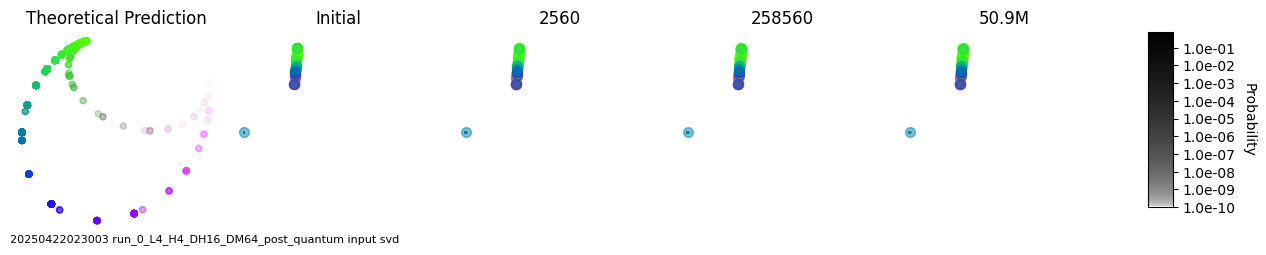

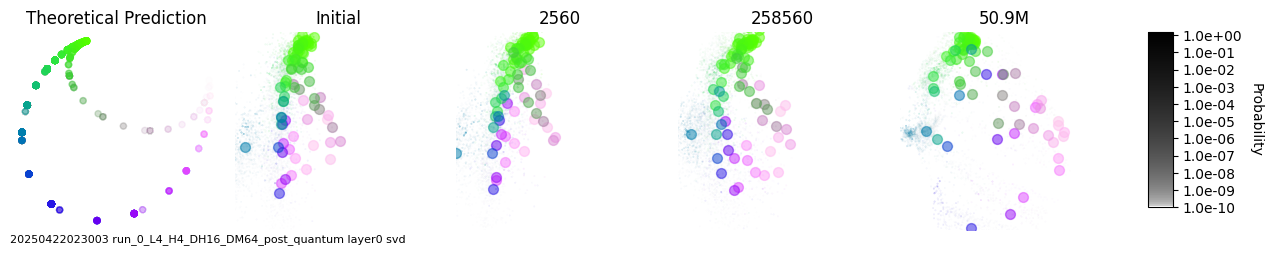

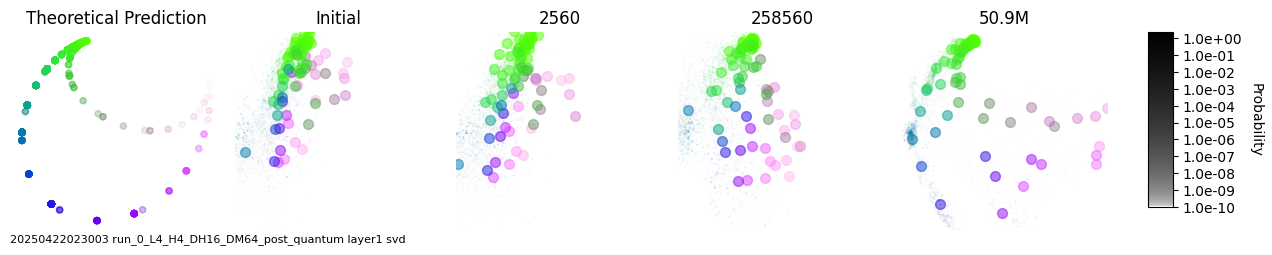

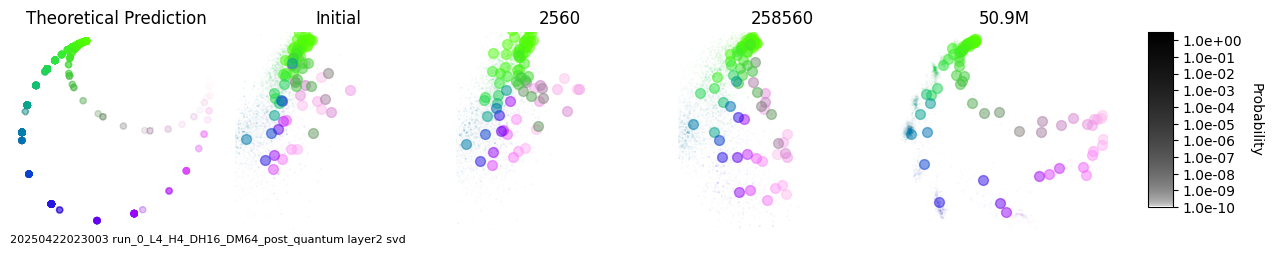

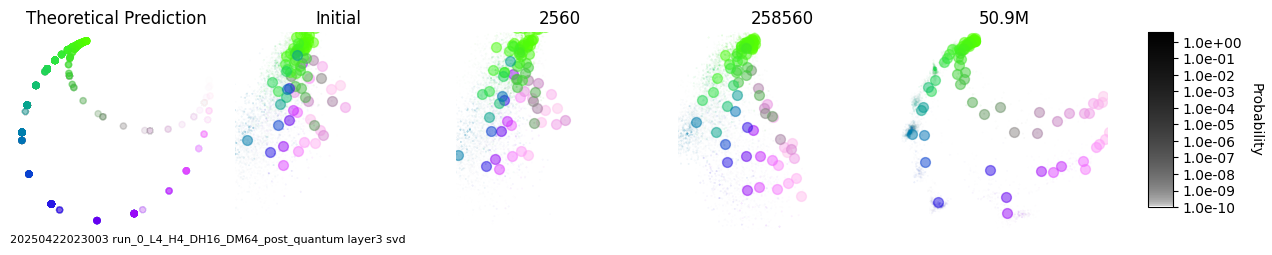

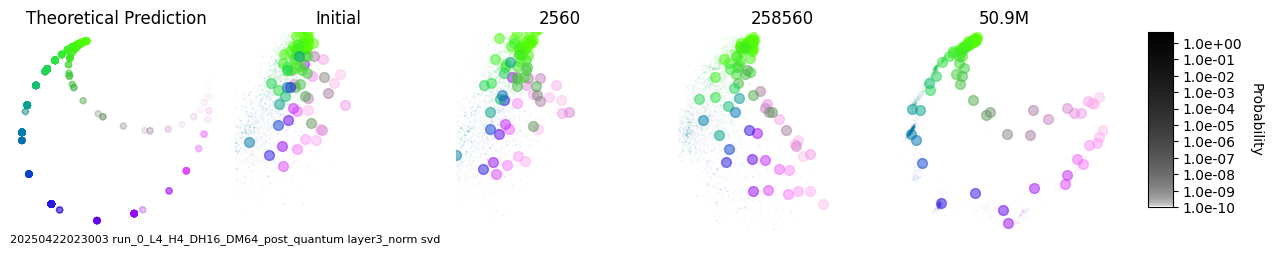

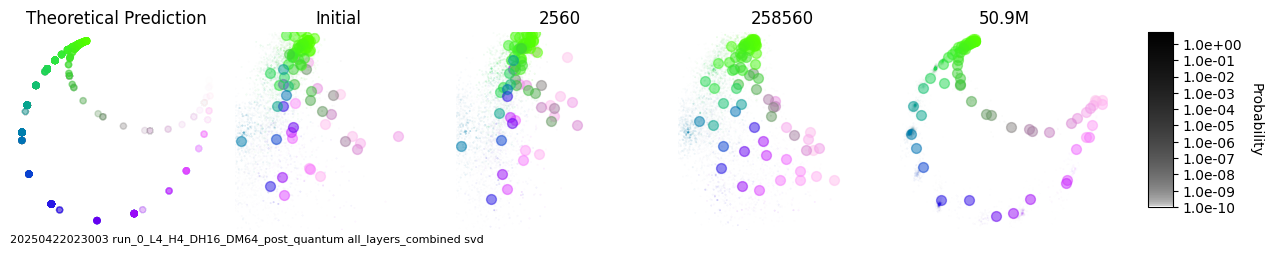

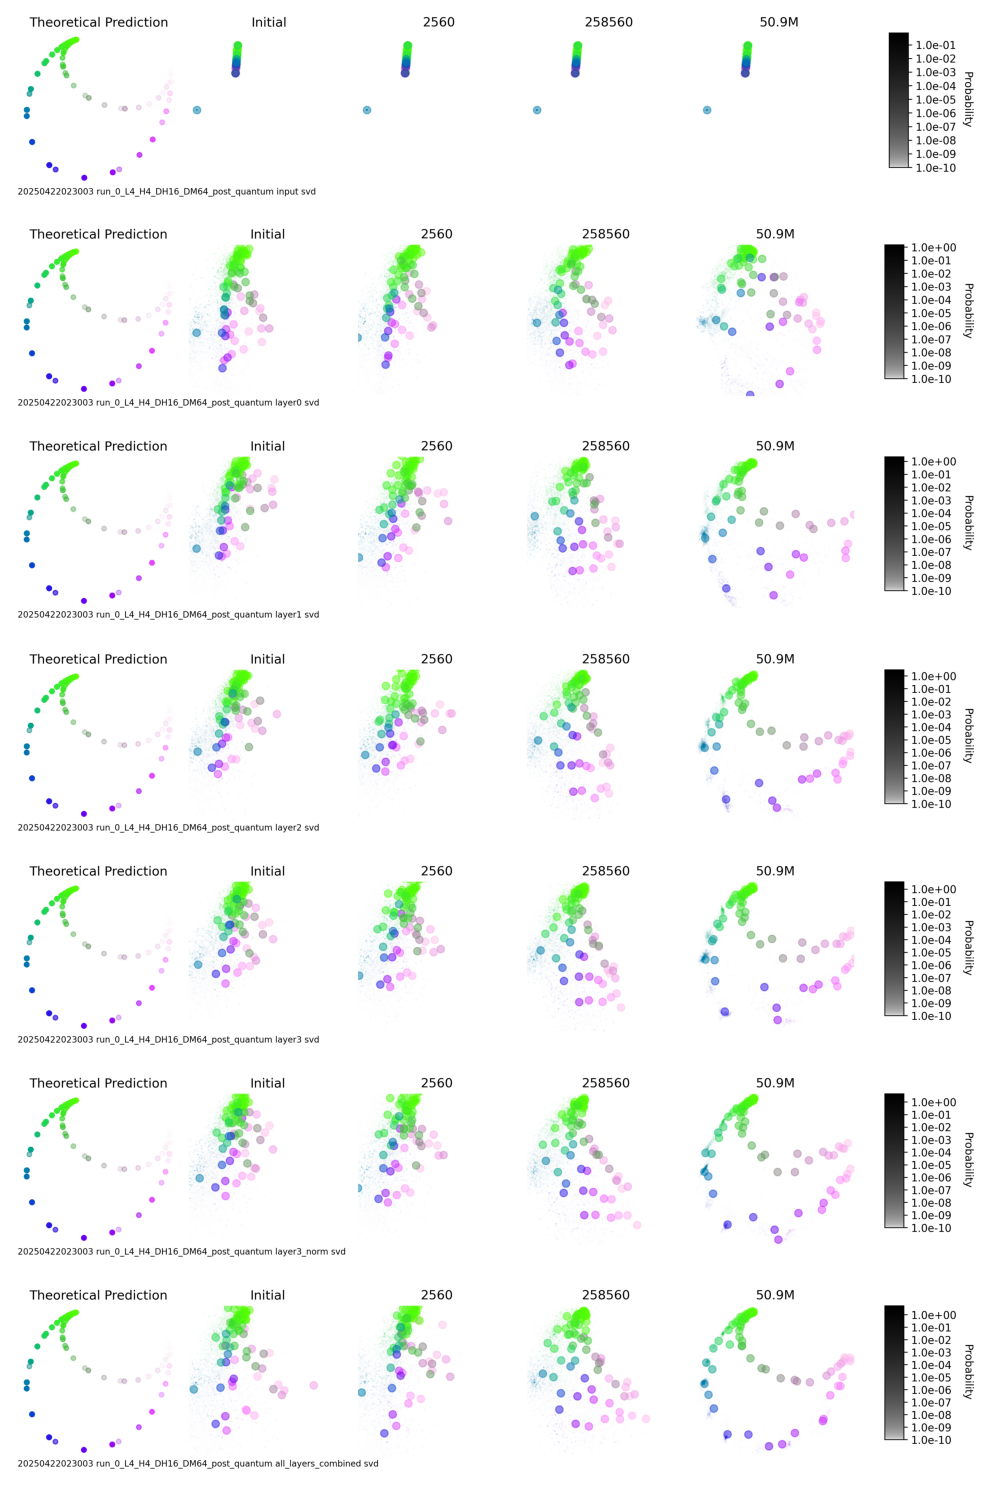

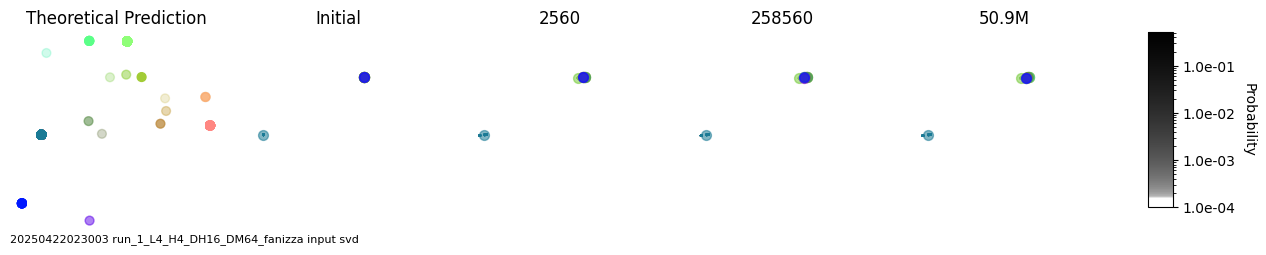

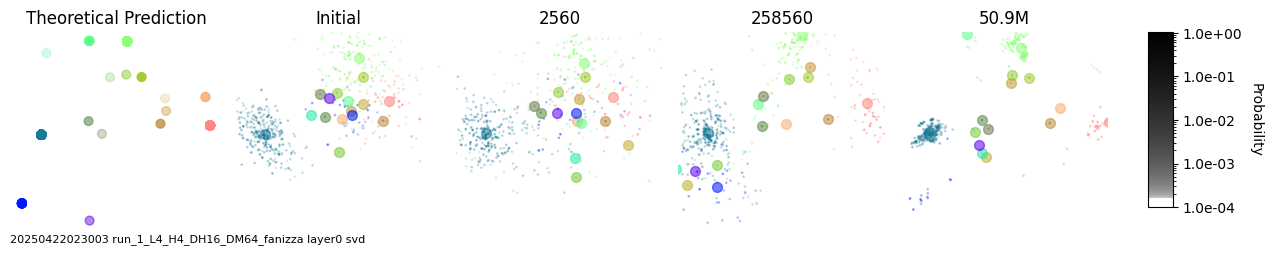

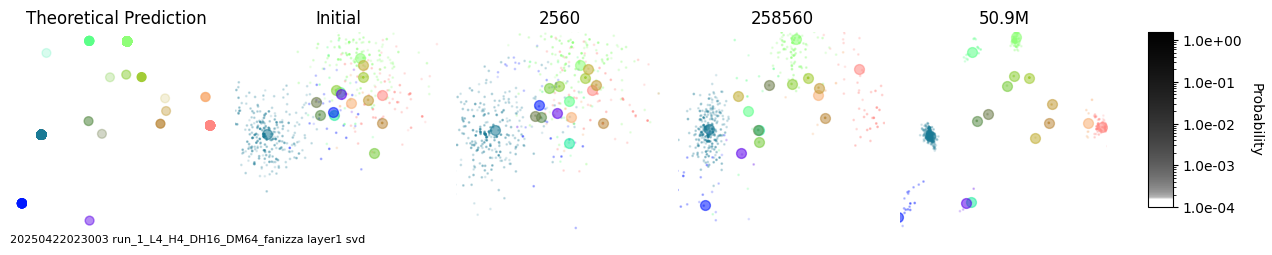

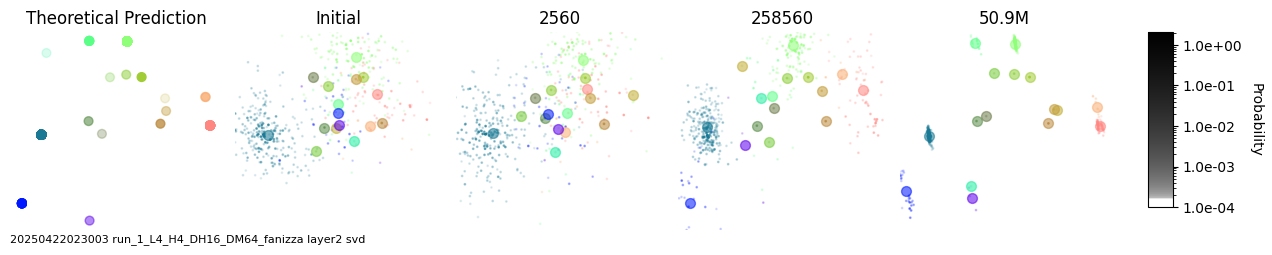

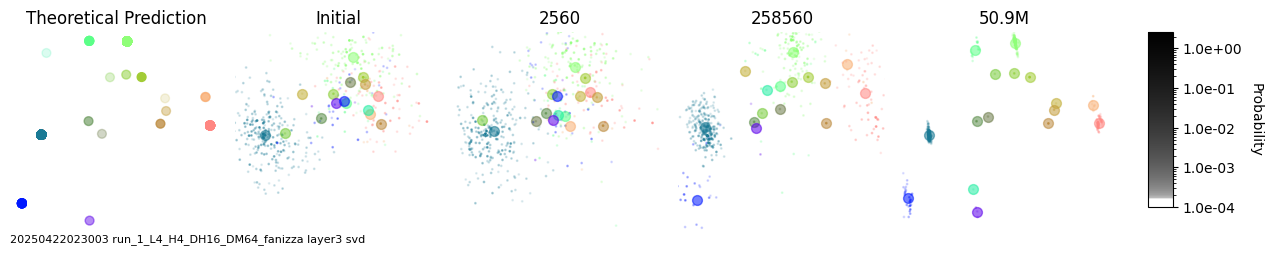

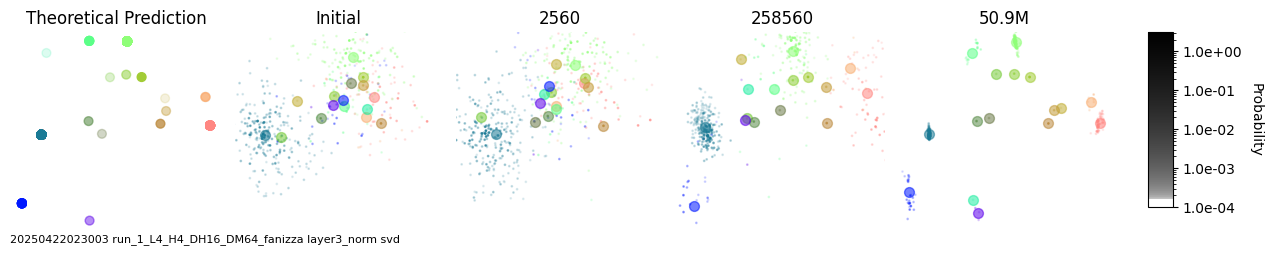

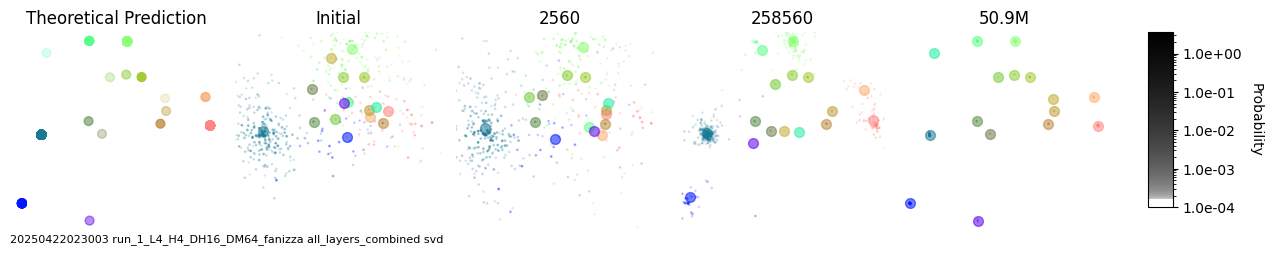

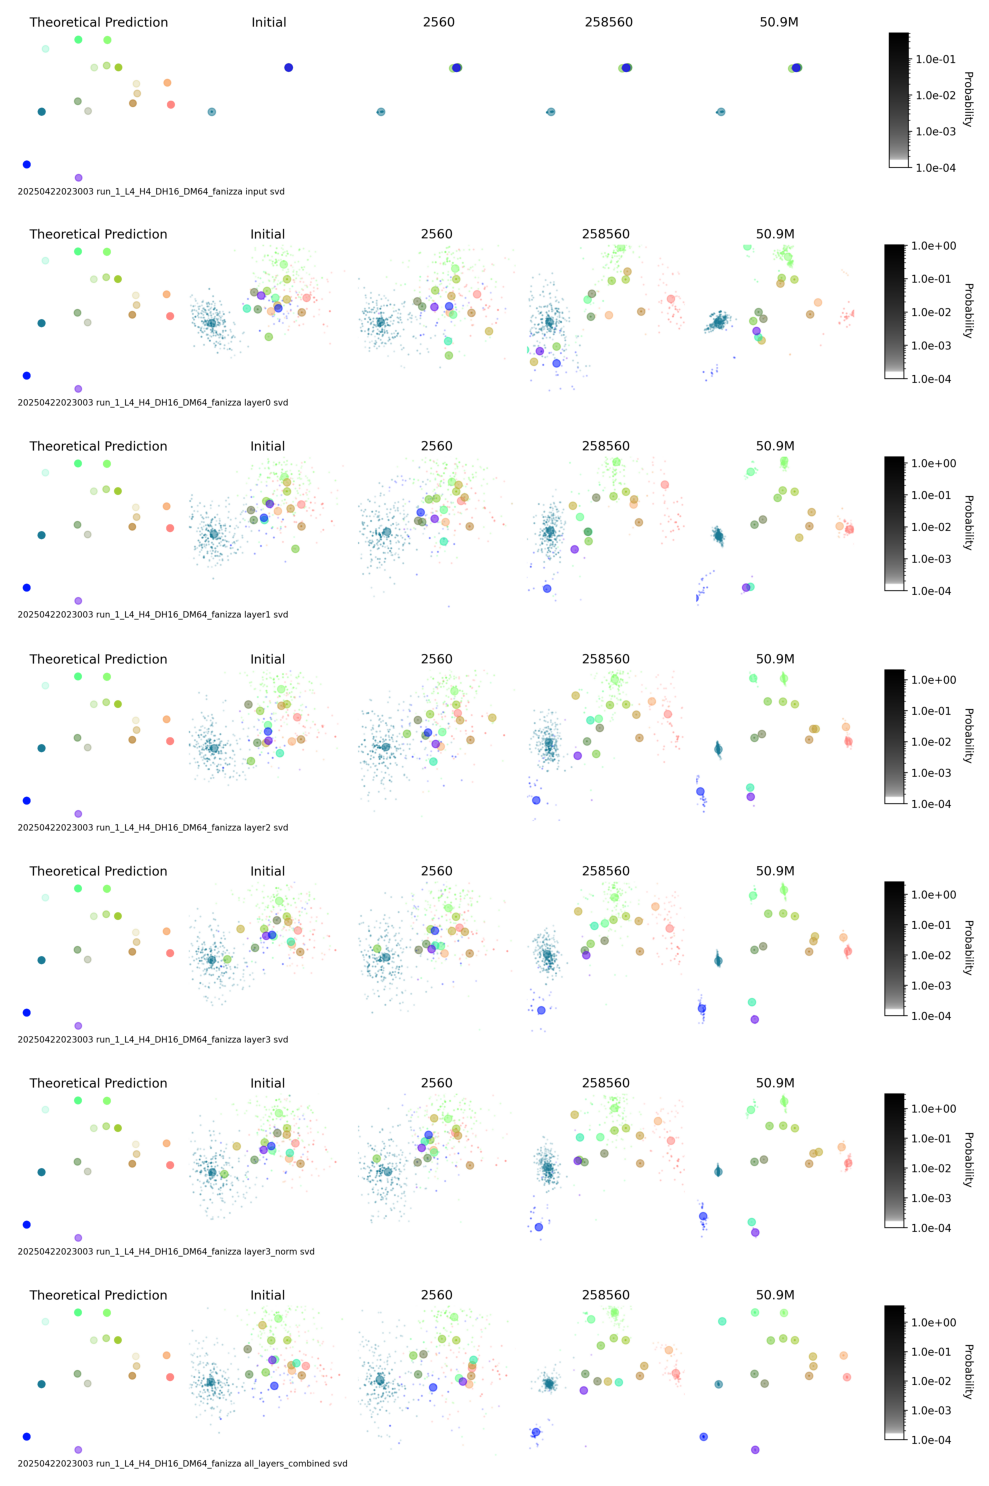

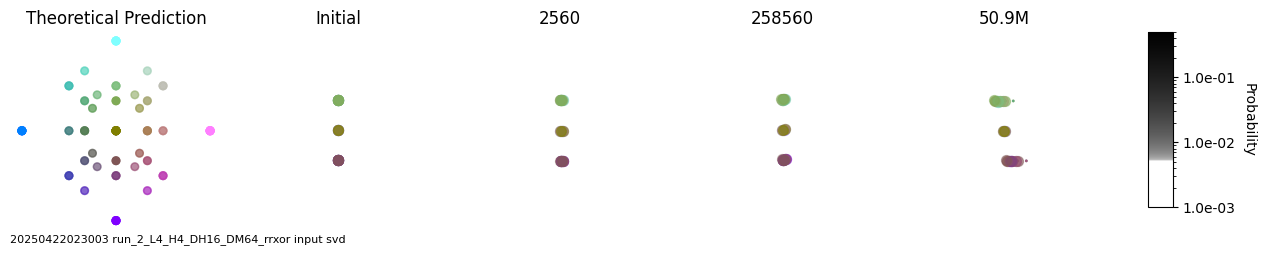

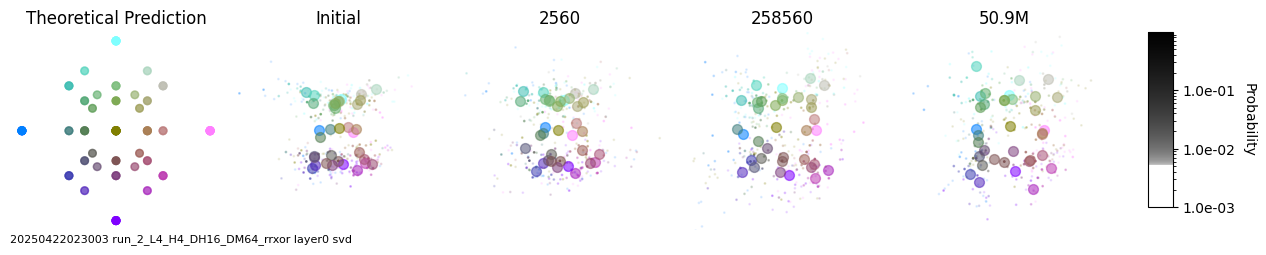

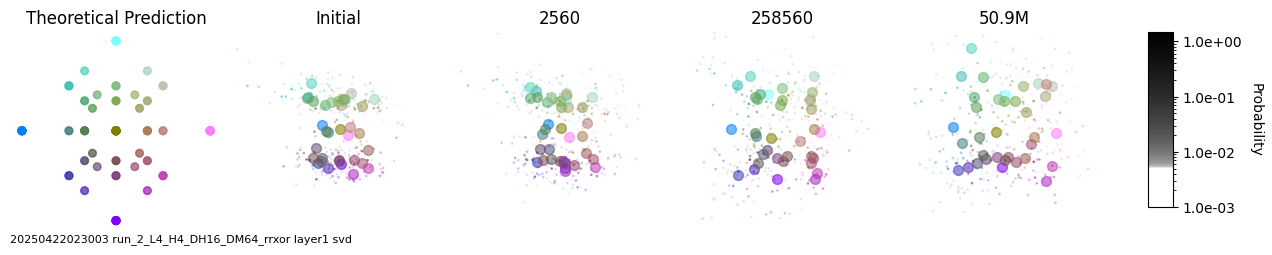

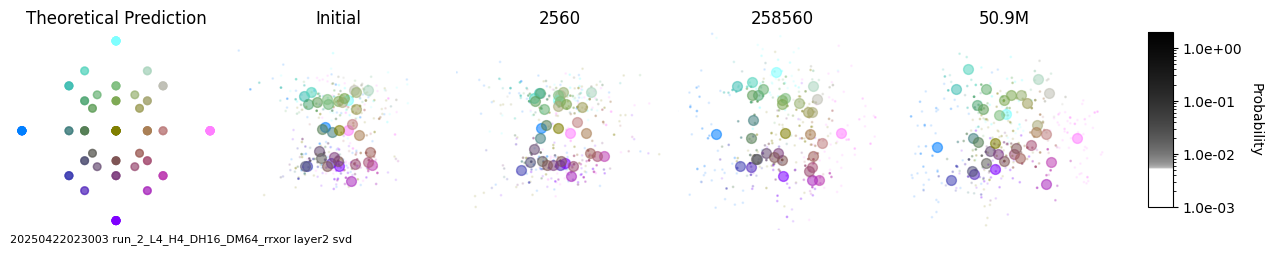

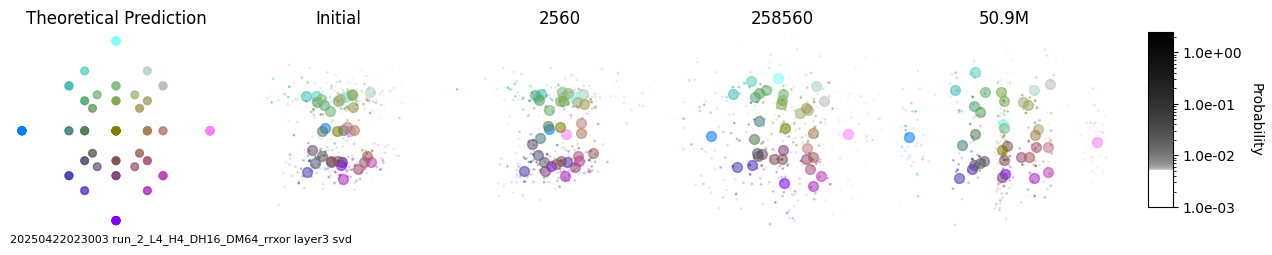

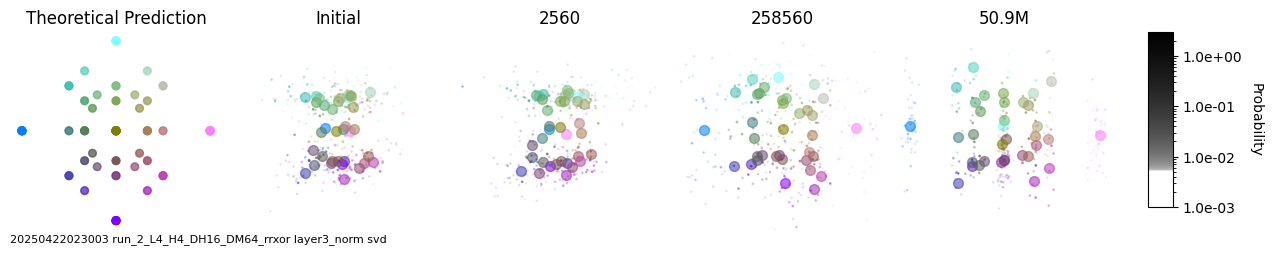

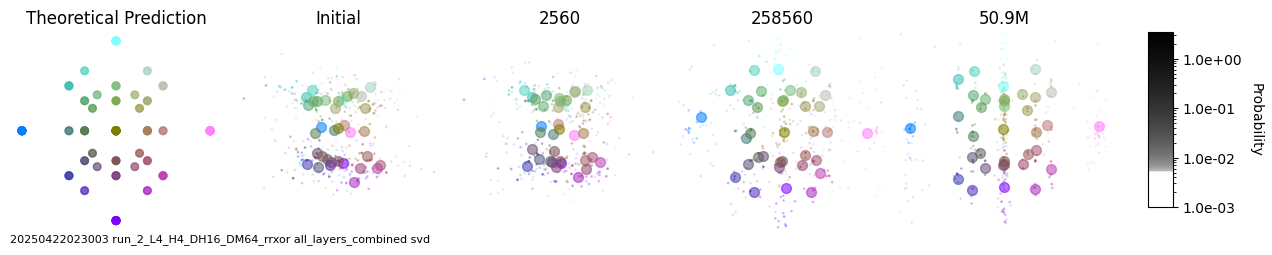

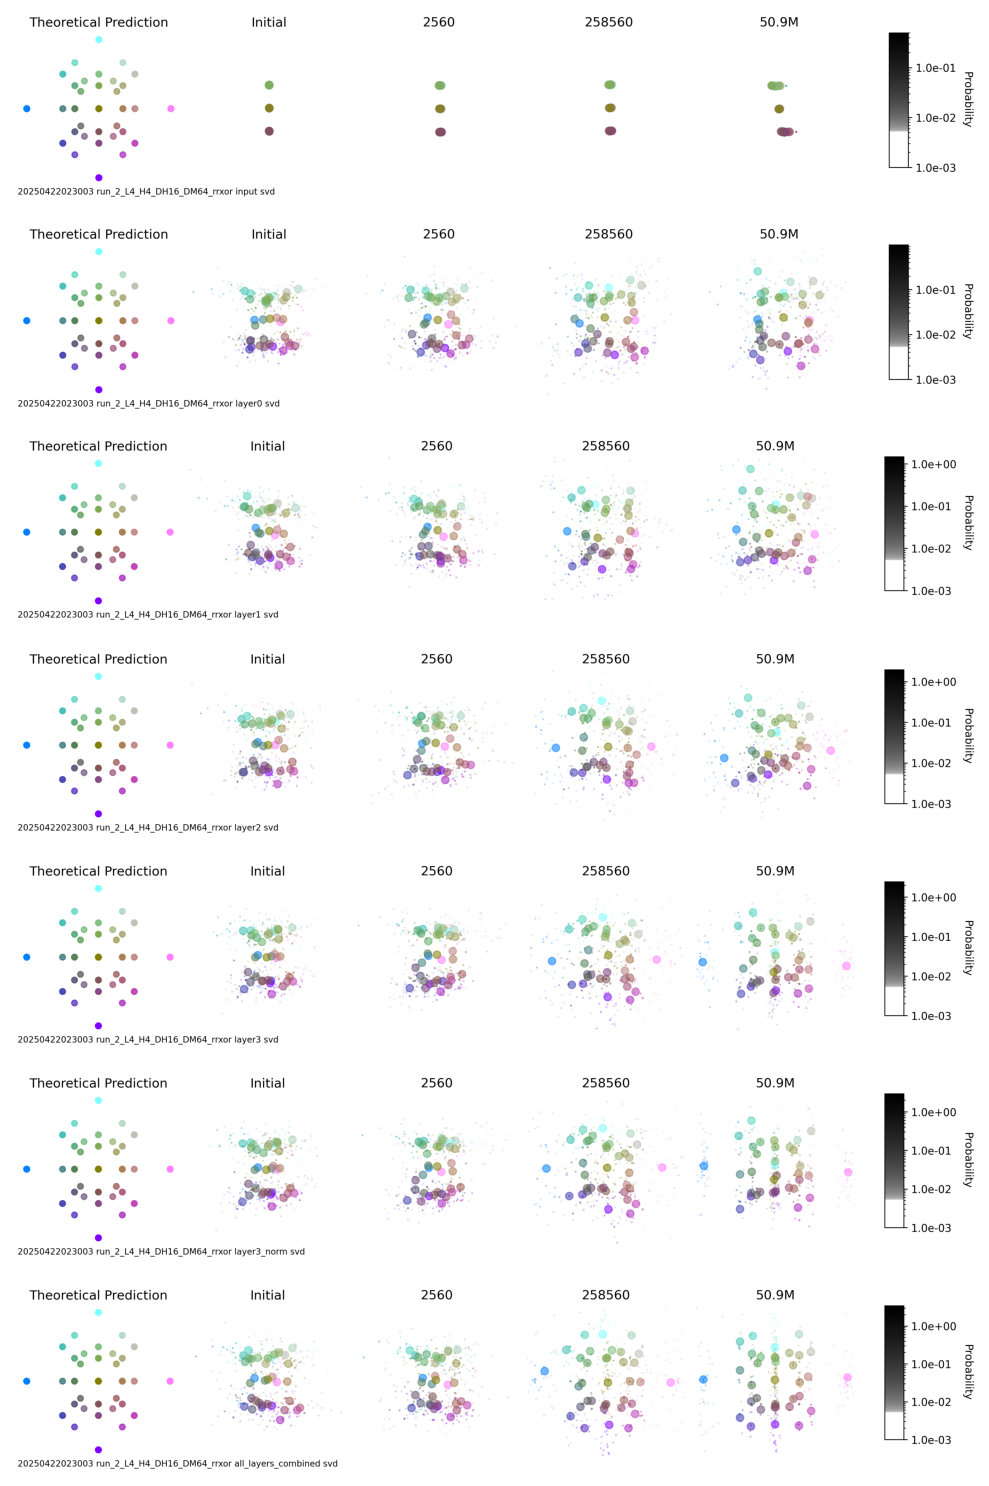

In [16]:
# Example usage TOM QUANTUM
# go into first key then the keys of that are the layer names
sweep_run_pairs = [
    # Mess3
    ("20241121152808", 71),  # RNN
    ("20241121152808", 63),  # GRU
    ("20241121152808", 55),  # LSTM
    ("20241205175736", 23),  # Transformer
    
    # RRXor
    ("20241121152808", 70),  # RNN
    ("20241121152808", 62),  # GRU
    ("20241121152808", 54),  # LSTM
    ("20241205175736", 22),  # Transformer
    
    # Fanizza
    ("20241121152808", 69),  # RNN
    ("20241121152808", 61),  # GRU
    ("20241121152808", 53),  # LSTM
    ("20241205175736", 21),  # Transformer
    
    # Tom Quantum A
    ("20241121152808", 65),  # RNN
    ("20241121152808", 57),  # GRU
    ("20241121152808", 49),  # LSTM
    ("20241205175736", 17),  # Transformer
    
    # Tom Quantum B
    ("20241121152808", 68),  # RNN
    ("20241121152808", 60),  # GRU
    ("20241121152808", 52),  # LSTM
    ("20241205175736", 20),  # Transformer
    
    # Post Quantum
    ("20241121152808", 64),  # RNN
    ("20241121152808", 56),  # GRU
    ("20241121152808", 48),  # LSTM
    ("20241205175736", 16),  # Transformer
]

sweep_run_pairs = [
    ("20250421221507", 1),
    ("20250421221507", 2),
    ("20250421221507", 3),
]



sweep_run_pairs = [
    ("20250422023003", 1),
    ("20250422023003", 2),
    ("20250422023003", 3),
]

print(sweep_run_pairs)
s3_loader = S3ModelLoader(use_company_credentials=True)
sweeps = s3_loader.list_sweeps()
#sweeps = ['20250327115247']
for sweep in sweeps:
    if '20250422023003' not in sweep:
        continue
    sweep_id = sweep
    runs = s3_loader.list_runs_in_sweep(sweep)
    for run in runs:
        run_id = run
        # if L4 not in run, skip
        print(run)
        if 'L4' not in run:
            print('skipping')
            continue


        should_process_run = False
        # Iterate through the list of desired pairs
        for target_sweep_id, target_run_int in sweep_run_pairs:
            # Check if the sweep ID matches exactly
            if sweep_id == target_sweep_id:
                # Check if the target run integer (as string) is a substring of the current run name
                if str(target_run_int) in run: 
                    should_process_run = True # Found a match
                    break # Exit the inner loop (checking pairs)
        
        # If no matching pair was found, skip to the next run
        if not should_process_run:
            continue 
        
        checkpoints_results = analyze_checkpoints(sweep, run, s3_loader)
        print('CHECKPOINTS RESULTS', checkpoints_results.keys())

        layer_names = checkpoints_results[list(checkpoints_results.keys())[0]].keys()
        print('LAYER NAMES', layer_names)
        output_paths = []
        for layer in layer_names:

            old_norm_dists = []
            new_norm_dists = []
            for checkpoint in checkpoints_results.keys():
                old_norm_dist = checkpoints_results[checkpoint][layer]['norm_dist']
                new_norm_dist = checkpoints_results[checkpoint][layer]['norm_dist']
                old_norm_dists.append(old_norm_dist)
                new_norm_dists.append(new_norm_dist)
            output_path = f'{sweep_id}_{run_id}_{layer}.png'
            model_type = checkpoints_results[checkpoint][layer]['final_metrics']['model_type']
            if 'tom_quantum' in run:
                fig = visualize_activation_results(
                    checkpoints_results,                # Dictionary with results for all checkpoints
                    layer=layer, # Which layer to visualize
                output_path=output_path,  # Optional: save the figure with sweep, run and layer info
                point_size={'truth': 0.15, 'pred': 0.05},  # Size of scatter points
                transformation='cbrt',      # Weight transformation method
                min_alpha=0.02,             # Minimum transparency
                text_bottom_left = f'{sweep_id} {run_id} {layer} {model_type}',

            )
            elif 'post_quantum' in run:
                fig = visualize_activation_results(
                    checkpoints_results,                # Dictionary with results for all checkpoints
                    layer=layer, # Which layer to visualize
                    output_path=output_path,  # Optional: save the figure
                    point_size={'truth': 20., 'pred': 0.1},  # Size of scatter points
                    transformation='cbrt',      # Weight transformation method
                    min_alpha=0.001 ,            # Minimum transparency,
                    com = True,
                    text_bottom_left = f'{sweep_id} {run_id} {layer} {model_type}',

                )
            elif 'rrxor' in run:
                # Example usage rrxor
                fig = visualize_activation_results(
                    checkpoints_results,                # Dictionary with results for all checkpoints
                    layer=layer, # Which layer to visualize
                    output_path=output_path,  # Optional: save the figure
                    point_size={'truth': 30., 'pred': 1},  # Size of scatter points
                    transformation='cbrt',      # Weight transformation method
                    min_alpha=0.1 ,            # Minimum transparency,
                    com = True,
                    project_to_simplex=False,
                    use_pca = True,
                    inds_to_plot = [1,2],
                    text_bottom_left = f'{sweep_id} {run_id} {layer} {model_type}',

                )
            elif 'fanizza' in   run:
                fig = visualize_activation_results(
                checkpoints_results,                # Dictionary with results for all checkpoints
                layer=layer, # Which layer to visualize
                output_path=output_path,  # Optional: save the figure
                point_size={'truth': 40., 'pred': 1},  # Size of scatter points
                transformation='cbrt',      # Weight transformation method
                min_alpha=0.1 ,            # Minimum transparency,
                com = True,
                inds_to_plot = [2,3],
                text_bottom_left = f'{sweep_id} {run} {layer} {model_type}',

            )
            elif 'mess3' in run:
                # Example usage mess3
                fig = visualize_activation_results(
                    checkpoints_results,                # Dictionary with results for all checkpoints
                    layer=layer, # Which layer to visualize
                    output_path=output_path,  # Optional: save the figure
                    point_size={'truth': 1., 'pred': 1},  # Size of scatter points
                    transformation='cbrt',      # Weight transformation method
                    min_alpha=0.1 ,            # Minimum transparency,
                    com = False,
                    project_to_simplex=True,
                    text_bottom_left = f'{sweep_id} {run_id} {layer} {model_type}',

                )
            output_paths.append(output_path)
        # now load all the saved figures and put them in a single figure vertically
        import matplotlib.pyplot as plt

        # make sure the paths are in order - sort them by the layer name
        # with 'input' first, then layer0, layer1, and then finally if something has norm and then all_layers_combined
        orders = ['input', 'layer0', 'layer1', 'layer2', 'layer3', 'layer3_norm', 'all_layers_combined']
        # Create a function to get the order index, returning a high number for items not in the list
        def get_order_index(path):
            # Extract the layer name from the path
            for layer_name in orders:
                if layer_name in path:
                    return orders.index(layer_name)
            return len(orders)  # Return a high number if no match found

        # Sort output_paths based on the order defined in orders list
        output_paths = sorted(output_paths, key=get_order_index)
        # Get all saved figures using output_paths
        saved_figures = [plt.imread(path) for path in output_paths]

        # Create a figure with subplots
        fig, axes = plt.subplots(nrows=len(saved_figures), ncols=1, figsize=(10, 15))

        # Loop through saved figures and add them to the subplots
        for i, ax in enumerate(axes):
            ax.imshow(saved_figures[i])
            ax.axis('off')

        # Adjust layout and display the figure
        plt.tight_layout()

        # save the figure
        # if folder does not exist, create it
        if not os.path.exists('./final_figs_pca'):
            os.makedirs('./final_figs_pca')
        plt.savefig(f'./final_figs_pca/{sweep_id}_{run_id}.png')

        # delete all the original figures
        for path in output_paths:
            os.remove(path)
